In [213]:
# author : Myron Kukhta (xkukht01)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [214]:
class SLR():
    '''
    
    Class for implementing a Simple Linear Regression(SLR) algorithm
    based on data on the ratio of sizes and prices of apartments in Moscow


    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to dataset
            _dataset [pd.DataFrame]: dataframe with dataset
            _solution [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solution = pd.DataFrame(columns=['sample_size', 'Y', 'Pr Y', 'A', 'B', 'E', 'X*E', 'r', 'R^2'])
        self._exp_cnt = 1


    def LoadDataSet(self)->None:
        '''
        
        Load dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = os.path.join(os.getcwd(), self.PATH_TO_DATASET)
        
        if not os.path.isfile(path):  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')

        self._dataset.to_excel(f'dataset/dataset.xlsx', index=True)  # store output
        



    def _Sampling(self, full_dataset:bool, random_sampling:bool, cnt:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            full_dataset    [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt             [int]: items number in sample

        Return:
            [np.array]: independet vars
            [np.array]: dependet vars
        '''
        sample = self._dataset.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 500)
        else:
            cnt_samples = cnt
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    
    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: predicted dependet data
            e [np.array]: error of predict
            viz_with_err [bool]: vizualization with error relation between original and predict Y
        '''
        
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:  # viz relation between predicted and real Y
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):  # one time iteration on many np arrays
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')  # e = y_real - y_predict

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

    def _LinearRelation(self, x:np.array, y:np.array, x_avg:float, y_avg:float)->tuple[float, float, np.array]:
        '''
        Description:
            Prediction for dependet variable

                    Y_PREDICT = a + b*X

                    a = avg(Y) - b*X

                         sum((X-avg(X))*(Y-avg(Y)))
                    b = -------------------------
                         sum((X-avg(X))**2)
        Parametrs:
            x [np.array]: independet variable
            y [np.array]: dependet variable
            x_avg [float]: average value of independet variable
            y_avg [float]: average value of dependet variable

        Return:
            [float]: lines start point on OY
            [float]: gradient
            [np.array]: predict of Y value

        '''
        b = np.sum(np.multiply((x - x_avg), (y - y_avg)))/np.sum(np.power((x - x_avg), 2))
        
        a = y_avg - b*x_avg

        y_predict = a + b*x

        return a, b, y_predict

    
    def _Evaluation(self, x, y, x_avg, y_avg, e)->tuple[float, float]:
        '''
        Description:
            Evaluation of correlation between dependet and independet vars

                        avg(X*Y) - avg(X)*avg(Y)
                    r = --------------------------
                        sqrt((avg(X**2)-avg(X)**2)*(avg(Y**2)-avg(Y)**2))

                    R_2 = 1 - SS_res/SS_tos
        Parametrs:
            
            x [np.array]: independet variable
            y [np.array]: dependet variable
            x_avg [float]: average value of independet variable
            y_avg [float]: average value of dependet variable
            e [np.array]: errors

        Return:
            
            [float]: correlation coeficient
            [float]: coeficient of Determination
        
        '''
        # correlation coeficient
        r = (np.mean(np.multiply(x, y)) - x_avg*y_avg)/np.sqrt((np.mean(np.power(x,2))-x_avg**2)*(np.mean(np.power(y,2))-y_avg**2))
        
        # residual sum of squares
        SS_res = np.sum(np.power(e, 2))
        # total sum of squares
        SS_tos = np.sum(np.power((y-y_avg), 2))

        # coeficient of Determination
        R_2 = 1 - SS_res/SS_tos
        
        return r, R_2

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, float, float, np.array, float, float]:
        '''

        Description:
            Core of SLR
        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data
        
        Return:
            [np.array]: prediction of dependet vars
            [float]: lines start point on OY
            [float]: gradient
            [np.array]: errors    
            [float]: correlation coeficient
            [float]: coeficient of Determinations

        '''

        # avg of dependet and independet var
        x_avg = np.mean(x)
        y_avg = np.mean(y)

        # find linear func for relation between dependet and independet vars
        a, b, y_predict = self._LinearRelation(x, y, x_avg, y_avg)
        
        # error
        e = y - y_predict

        # evaluation
        r, R_2 = self._Evaluation(x, y, x_avg, y_avg, e)

        return y_predict, a, b, e, r, R_2
        


    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, cnt_sample:int, viz_with_err:bool)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample [int]: items number in sample
            viz_with_err [bool]: vizualization with error relation between original and predict Y

        '''
        iter_count = count

        self._solution.drop(self._solution.index,inplace=True)
        
        if iter_count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            iter_count = 1
        
        for _ in range(iter_count):  # repetitions

            x, y, = self._Sampling(full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            y_predict, a, b, e, r, R_2 = self._Alg(x, y)  # SLR

            self._solution.loc[len(self._solution)] = {'sample_size':x.size, 'Y':np.sum(y), 'Pr Y':np.sum(y_predict), 'A': a, 'B': b, 'E':np.sum(e), 'X*E':np.sum(np.multiply(x, e)), 'r': r, 'R^2':R_2}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)
        
        self._solution.to_excel(f'solutions/Experiment_{self._exp_cnt}.xlsx', index=True)  # store output
        self._exp_cnt += 1


In [215]:
# Prepare data

SLR_solution = SLR()

SLR_solution.LoadDataSet()


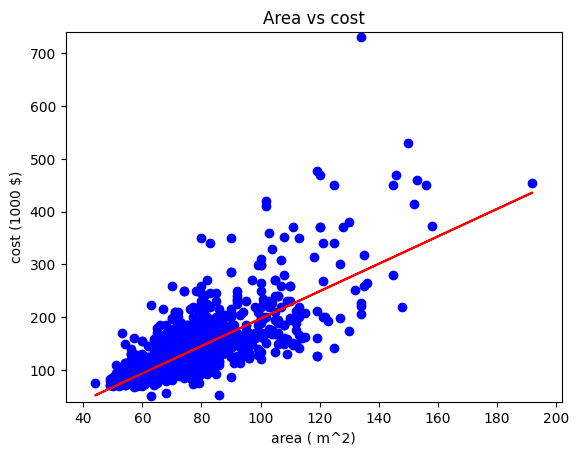

In [216]:
# Experiment № 1
# Description: SLR with full dataset

SLR_solution.Experiment(count=1, full_dataset=True, random_sampling=False, cnt_sample=0, viz_with_err=False)

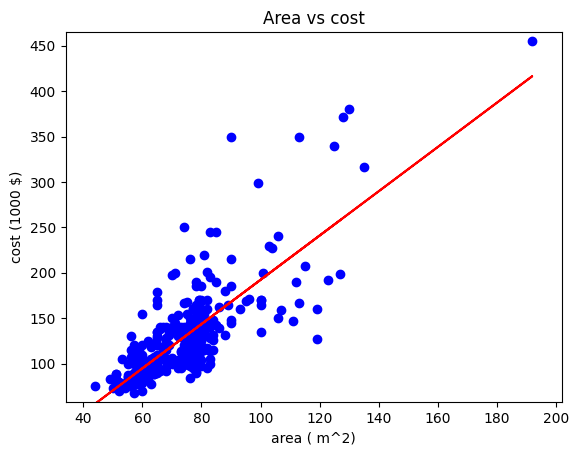

In [217]:
# Experiment № 2
# Description: SLR with datasets sample

SLR_solution.Experiment(count=1, full_dataset=False, random_sampling=True, cnt_sample=0, viz_with_err=False)

Point 1: y_original=451, y_predict=419.8014577337887, error=31.19854226621129
Point 2: y_original=170, y_predict=133.43254619294802, error=36.567453807051976
Point 3: y_original=165, y_predict=194.07537451924372, error=-29.075374519243724
Point 4: y_original=82, y_predict=79.52780990290742, error=2.4721900970925788
Point 5: y_original=225, y_predict=204.1825125736263, error=20.817487426373702
Point 6: y_original=125, y_predict=170.49205239235096, error=-45.492052392350956
Point 7: y_original=175, y_predict=214.28965062800893, error=-39.28965062800893
Point 8: y_original=129, y_predict=116.58731610231033, error=12.412683897689675
Point 9: y_original=110, y_predict=86.26590193916249, error=23.73409806083751
Point 10: y_original=88, y_predict=82.89685592103496, error=5.103144078965045
Point 11: y_original=110, y_predict=153.64682230171326, error=-43.64682230171326
Point 12: y_original=87, y_predict=79.52780990290742, error=7.472190097092579
Point 13: y_original=102, y_predict=89.634947957

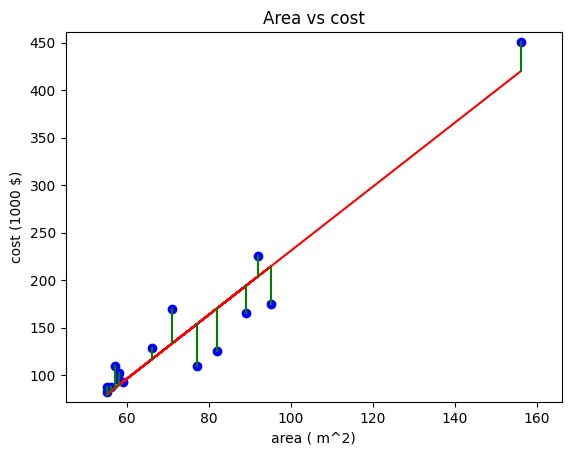

In [218]:
# Experiment № 3
# Description: SLR with datasets sample

SLR_solution.Experiment(count=1, full_dataset=False, random_sampling=False, cnt_sample=15,  viz_with_err=True)

In [219]:
# Experiment № 4
# Description: many SLR with datasets sample

SLR_solution.Experiment(count=50, full_dataset=False, random_sampling=True, cnt_sample=0,  viz_with_err=False)